# Sales Prediction Demo Notebook

A Jupyter notebook for demonstrating the Sales Prediction Web App functionality.

This notebook will:
- Verify environment and required files
- Load the scaler and any available models
- Show feature engineering for date-based inputs
- Run a single prediction example
- Run a batch prediction example and save a predictions CSV


## 1. Setup Environment

- Ensure the following files exist in either this folder (`my_sales_prediction_app/`) or the project root:
  - `scaler.pkl`
  - One or more model files: `rf_model.pkl`, `lgbm_model.pkl`, `catboost_model.pkl`, `ridge_model.pkl`
- Optional inputs:
  - `train2.csv` for dropdown options in the web app
  - `test.csv` for batch prediction demo

We will install/run with the same libs used by the web app.

In [18]:
# If running in a clean environment, ensure dependencies are present.
# You can uncomment the following line to install packages within the notebook.
# !pip install -q flask pandas numpy scikit-learn lightgbm catboost

import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

print("Python OK. Versions:")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

# Define search paths for artifacts
NB_DIR = Path.cwd()
ROOT_DIR = NB_DIR.parent  # project root
UPLOADS_DIR = NB_DIR / 'uploads'
UPLOADS_DIR.mkdir(exist_ok=True)

ARTIFACT_CANDIDATE_DIRS = [NB_DIR, ROOT_DIR]

MODEL_FILES = {
    'random_forest': 'rf_model.pkl',
    'lightgbm': 'lgbm_model.pkl',
    'catboost': 'catboost_model.pkl',
    'ridge': 'ridge_model.pkl',
}

# Small helper to find a file in either folder
def find_file(filename):
    for base in ARTIFACT_CANDIDATE_DIRS:
        p = base / filename
        if p.exists():
            return p
    return None


Python OK. Versions:
numpy: 2.2.6
pandas: 2.3.1


## 2. Load Pre-trained Models

Load the scaler and any available models. Some models (e.g., LightGBM/CatBoost) require their packages installed to unpickle successfully.

In [19]:
# Load scaler
scaler_path = find_file('scaler.pkl')
if scaler_path is None:
    raise FileNotFoundError("scaler.pkl not found in template folder or project root")

with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
print("Loaded scaler from:", scaler_path)

# Load models dynamically
models = {}
for key, fname in MODEL_FILES.items():
    p = find_file(fname)
    if p is not None:
        try:
            with open(p, 'rb') as f:
                models[key] = pickle.load(f)
            print(f"Loaded model {key} from: {p}")
        except Exception as e:
            print(f"WARNING: Failed to load {fname}: {e}")

if not models:
    print("WARNING: No models loaded. Add at least one of:", list(MODEL_FILES.values()))
else:
    print("Available models:", list(models.keys()))


Loaded scaler from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/scaler.pkl
Loaded model lightgbm from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/lgbm_model.pkl
Loaded model catboost from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/catboost_model.pkl
Loaded model ridge from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/ridge_model.pkl
Available models: ['lightgbm', 'catboost', 'ridge']


/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 3. Feature Engineering for Predictions

We will convert a given `date` into:
- `month`, `day`, `dayofweek`, `dayofyear`, `weekofyear`

The final feature vector expected by the scaler/models is:
`[store, item, month, day, dayofweek, dayofyear, weekofyear]`.

In [20]:
import datetime as dt

def make_features(store: int, item: int, date: pd.Timestamp):
    month = date.month
    day = date.day
    dayofweek = date.dayofweek
    dayofyear = date.dayofyear
    weekofyear = int(date.isocalendar().week)
    return [store, item, month, day, dayofweek, dayofyear, weekofyear]

# Example
example_date = pd.to_datetime('2024-06-15')
print("Example features:", make_features(1, 1, example_date))


Example features: [1, 1, 6, 15, 5, 167, 24]


## 4. Single Prediction Example

Pick the first available model and run a single prediction for a chosen store, item, and date.

In [21]:
if not models:
    print("No models available to run a single prediction.")
else:
    # Choose the model: prefer random_forest, else first one
    model = models.get('random_forest') or next(iter(models.values()))
    chosen_key = 'random_forest' if 'random_forest' in models else list(models.keys())[0]

    store_id = 1
    item_id = 1
    date = pd.to_datetime('2024-06-15')

    feats = make_features(store_id, item_id, date)
    scaled = scaler.transform([feats])
    y_pred = model.predict(scaled)
    y_pred_round = int(np.round(np.ravel(y_pred)[0]))

    print(f"Model: {chosen_key}")
    print("Features:", feats)
    print("Predicted sales:", y_pred_round)

    # ------------------------------------------------------------
    # Evaluation: R2, RMSE, RMSPE on a holdout split from train2.csv
    # Only for models that are currently loaded
    # ------------------------------------------------------------
    from sklearn.metrics import r2_score, mean_squared_error

    train2_path = find_file('train2.csv')
    if train2_path is None:
        print("train2.csv not found. Skipping evaluation metrics.")
    else:
        print("\nEvaluating models on holdout split from:", train2_path)
        df_full = pd.read_csv(train2_path, parse_dates=['date'])
        required_cols = {'date', 'store', 'item', 'sales'}
        if not required_cols.issubset(df_full.columns):
            print("train2.csv missing required columns, skipping evaluation.")
        else:
            # Feature engineering
            df_full['month'] = df_full['date'].dt.month
            df_full['day'] = df_full['date'].dt.day
            df_full['dayofweek'] = df_full['date'].dt.dayofweek
            df_full['dayofyear'] = df_full['date'].dt.dayofyear
            df_full['weekofyear'] = df_full['date'].dt.isocalendar().week.astype(int)

            feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
            df_full = df_full.sort_values('date').reset_index(drop=True)
            n = len(df_full)
            n_test = max(1, int(0.2 * n))  # last 20% as test
            test_df = df_full.iloc[-n_test:]

            X_test = test_df[feature_cols]
            y_test = test_df['sales'].to_numpy()
            X_test_scaled = scaler.transform(X_test)

            def rmspe(y_true, y_pred):
                y_true = np.asarray(y_true)
                y_pred = np.asarray(y_pred)
                eps = 1e-8
                mask = y_true != 0
                if not np.any(mask):
                    return np.nan
                pe = (y_pred[mask] - y_true[mask]) / (y_true[mask] + eps)
                return float(np.sqrt(np.mean(pe ** 2)) * 100.0)

            rows = []
            for key, mdl in models.items():
                try:
                    pred = mdl.predict(X_test_scaled)
                    pred = np.ravel(pred)
                    r2 = float(r2_score(y_test, pred))
                    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
                    rmspe_val = rmspe(y_test, pred)
                    rows.append({
                        'Model': key.replace('_', ' ').title(),
                        'R2 Score (Test)': round(r2, 4),
                        'RMSE (Test)': round(rmse, 4),
                        'RMSPE (Test)': (None if np.isnan(rmspe_val) else f"{rmspe_val:.2f}%"),
                    })
                except Exception as e:
                    rows.append({
                        'Model': key.replace('_', ' ').title(),
                        'R2 Score (Test)': 'Error',
                        'RMSE (Test)': 'Error',
                        'RMSPE (Test)': f'Error: {e}',
                    })

            if rows:
                metrics_df = pd.DataFrame(rows)[['Model', 'R2 Score (Test)', 'RMSE (Test)', 'RMSPE (Test)']]
                # Save metrics
                out_path = UPLOADS_DIR / 'model_metrics.csv'
                metrics_df.to_csv(out_path, index=False)
                print("\nMetrics (saved to", out_path, "):")
                display(metrics_df)
            else:
                print("No metrics computed.")

    # End of evaluation block
    # ------------------------------------------------------------


/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Model: lightgbm
Features: [1, 1, 6, 15, 5, 167, 24]
Predicted sales: 28

Evaluating models on holdout split from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/train2.csv


/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Metrics (saved to /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/my_sales_prediction_app/uploads/model_metrics.csv ):


,Model,R2 Score (Test),RMSE (Test),RMSPE (Test)
0,Lightgbm,0.8685,11.4415,18.99%
1,Catboost,0.9010,9.9261,17.99%
2,Ridge,0.0605,30.5791,85.03%


## 5. Batch Prediction Example

Load a CSV named `test.csv` from either the template folder or the project root. The file must contain `date`, `store`, `item` columns. We will write the output to `uploads/predictions_test_notebook.csv`.

In [22]:
# Locate a test.csv in either location
cand = find_file('test.csv')
if cand is None:
    print("No test.csv found. Create one with columns: date, store, item.")
else:
    print("Using test.csv:", cand)

if cand is not None and models:
    df = pd.read_csv(cand, parse_dates=['date'])
    required = {'date', 'store', 'item'}
    if not required.issubset(df.columns):
        raise ValueError(f"test.csv must contain columns: {sorted(required)}")

    # Feature engineering
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

    feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
    X = df[feature_cols]
    X_scaled = scaler.transform(X)

    model = models.get('random_forest') or next(iter(models.values()))
    preds = model.predict(X_scaled)
    df['predicted_sales'] = np.round(preds).astype(int)

    out_path = UPLOADS_DIR / 'predictions_test_notebook.csv'
    df.to_csv(out_path, index=False)
    print("Wrote:", out_path)


Using test.csv: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/test.csv
Wrote: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/my_sales_prediction_app/uploads/predictions_test_notebook.csv


/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 6. Evaluate Model Performance (R2, RMSE, RMSPE)

This section computes R2, RMSE, and RMSPE for the available model(s).

Data requirements:
- A labeled CSV with columns: `date`, `store`, `item`, and a target label such as `sales` (preferred) or `target`/`y`.
- The notebook will search for `test.csv` first; if it does not contain a label column, it will fall back to `train2.csv` if available.

By default, it evaluates only a single model (the preferred available one). You can switch to evaluate all loaded models by toggling a flag below.

In [23]:
from sklearn.metrics import r2_score, mean_squared_error

# Toggle: evaluate only one preferred model or all loaded models
EVAL_SINGLE_ONLY = True  # set to False to evaluate all available models

# Define acceptable label column names (in order of preference)
LABEL_CANDIDATES = ['sales', 'target', 'y']

# Helper to compute RMSPE (as a percentage)
def rmspe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    # Avoid division by zero: mask zeros in y_true
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    pct_err_sq = ((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2
    return float(np.sqrt(np.mean(pct_err_sq)) * 100.0)

# Locate labeled evaluation data
label_col = None

def find_labeled_dataset():
    global label_col
    # Prefer test.csv
    test_path = find_file('test.csv')
    if test_path is not None:
        df = pd.read_csv(test_path, parse_dates=['date'])
        for c in LABEL_CANDIDATES:
            if c in df.columns:
                label_col = c
                return df, test_path
    # Fallback to train2.csv
    train2_path = find_file('train2.csv')
    if train2_path is not None:
        df = pd.read_csv(train2_path, parse_dates=['date']) if 'date' in pd.read_csv(train2_path, nrows=1).columns else pd.read_csv(train2_path)
        for c in LABEL_CANDIDATES:
            if c in df.columns:
                label_col = c
                return df, train2_path
    return None, None

edata, epath = find_labeled_dataset()
if edata is None:
    print("No labeled dataset found. Please provide a CSV with columns: date, store, item, and a label column (e.g., 'sales').")
else:
    print("Using labeled dataset:", epath)
    # Ensure date column is datetime if present
    if 'date' in edata.columns and not np.issubdtype(edata['date'].dtype, np.datetime64):
        edata['date'] = pd.to_datetime(edata['date'])

    # Validate required feature columns
    required = {'store', 'item'}
    if not required.issubset(edata.columns):
        raise ValueError(f"Evaluation dataset must contain columns: {sorted(required)}")

    # If date exists, engineer features; else, we cannot compute temporal features
    if 'date' in edata.columns:
        edata['month'] = edata['date'].dt.month
        edata['day'] = edata['date'].dt.day
        edata['dayofweek'] = edata['date'].dt.dayofweek
        edata['dayofyear'] = edata['date'].dt.dayofyear
        edata['weekofyear'] = edata['date'].dt.isocalendar().week.astype(int)
    else:
        # Attempt to use precomputed columns if they exist; otherwise, error
        needed = ['month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
        if not set(needed).issubset(edata.columns):
            raise ValueError("No 'date' column and missing precomputed temporal features. Provide 'date' or all temporal feature columns.")

    feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
    X_eval = edata[feature_cols]
    y_true = edata[label_col].to_numpy()

    # Scale features
    X_eval_scaled = scaler.transform(X_eval)

    # Determine which models to evaluate
    if not models:
        print("No models loaded. Place a model pickle next to the notebook or in the project root.")
    else:
        eval_models = {}
        if EVAL_SINGLE_ONLY:
            # Prefer random_forest, else first available
            chosen_key = 'random_forest' if 'random_forest' in models else list(models.keys())[0]
            eval_models[chosen_key] = models[chosen_key]
        else:
            eval_models = models

        rows = []
        for key, mdl in eval_models.items():
            y_pred = mdl.predict(X_eval_scaled)
            r2 = r2_score(y_true, y_pred)
            rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
            r_mspe = rmspe(y_true, y_pred)
            rows.append({
                'Model': key.replace('_', ' ').title(),
                'R2 Score (Test)': round(float(r2), 4),
                'RMSE (Test)': round(rmse, 4),
                'RMSPE (Test)': f"{r_mspe:.2f}%" if not np.isnan(r_mspe) else 'NA'
            })

        results_df = pd.DataFrame(rows)
        # Order columns as in the screenshot
        results_df = results_df[['Model', 'R2 Score (Test)', 'RMSE (Test)', 'RMSPE (Test)']]
        print("\nPerformance Metrics:")
        display(results_df)


Using labeled dataset: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/train2.csv


/Users/ayush/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Performance Metrics:


,Model,R2 Score (Test),RMSE (Test),RMSPE (Test)
0,Lightgbm,0.884,9.8089,24.68%


## 7. Visualization Setup

We will install and import visualization libraries (Seaborn, Matplotlib, Plotly) used throughout the plots below.

In [24]:
# Ensure visualization libraries are available
import sys, subprocess

def _ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        __import__(name)
        print(f"{pkg} is available")
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        __import__(name)
        print(f"{pkg} installed")

for _pkg, _imp in [
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("plotly", "plotly"),
]:
    _ensure(_pkg, _imp)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Matplotlib/Seaborn defaults
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


matplotlib is available
seaborn is available
plotly is available


## 8. Load Data for Visualization

We will read `train2.csv`, engineer date-based features, and prepare a DataFrame for plots.

In [25]:
train_path = find_file('train2.csv')
if train_path is None:
    print("train2.csv not found. Visualizations will be limited.")
    df_vis = None
else:
    df_vis = pd.read_csv(train_path, parse_dates=['date'])
    # Engineer temporal features
    df_vis['month'] = df_vis['date'].dt.month
    df_vis['day'] = df_vis['date'].dt.day
    df_vis['dayofweek'] = df_vis['date'].dt.dayofweek
    df_vis['dayofyear'] = df_vis['date'].dt.dayofyear
    df_vis['weekofyear'] = df_vis['date'].dt.isocalendar().week.astype(int)
    display(df_vis.head())


,date,store,item,sales,month,day,dayofweek,dayofyear,weekofyear
0,2013-01-01,1,1,13,1,1,1,1,1
1,2013-01-02,1,1,11,1,2,2,2,1
2,2013-01-03,1,1,14,1,3,3,3,1
3,2013-01-04,1,1,13,1,4,4,4,1
4,2013-01-05,1,1,10,1,5,5,5,1


## 9. Time Series Visualizations

- Daily sales trend (overall and for a specific store-item)
- Rolling averages to smooth volatility
- Interactive Plotly line charts

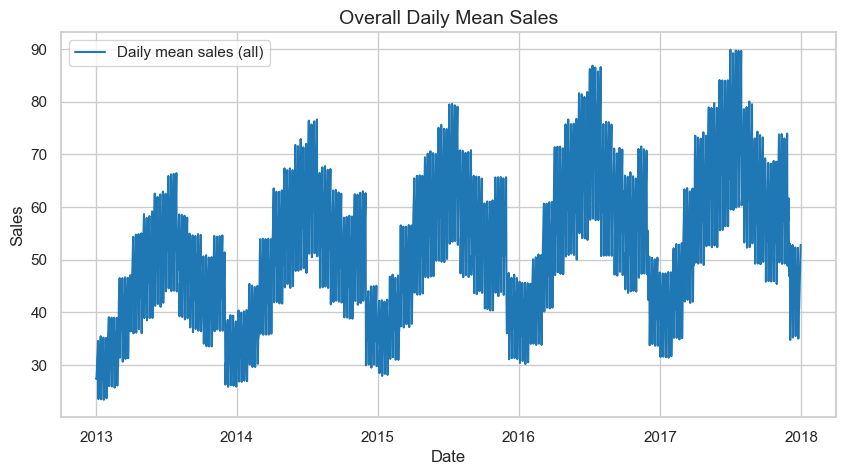

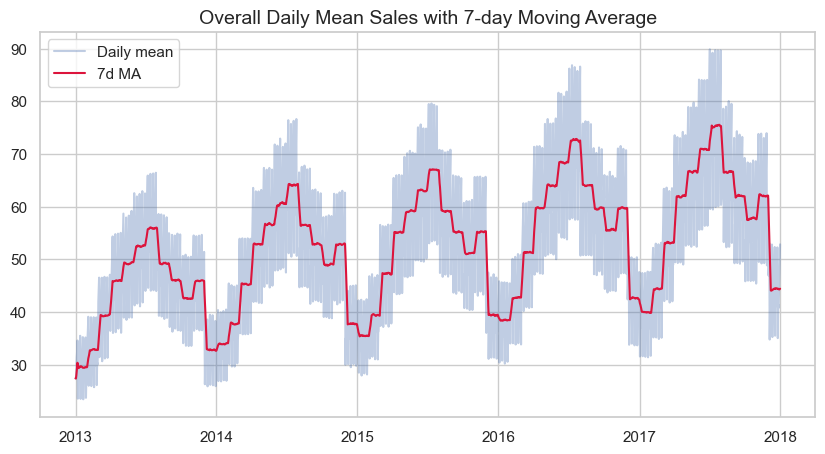

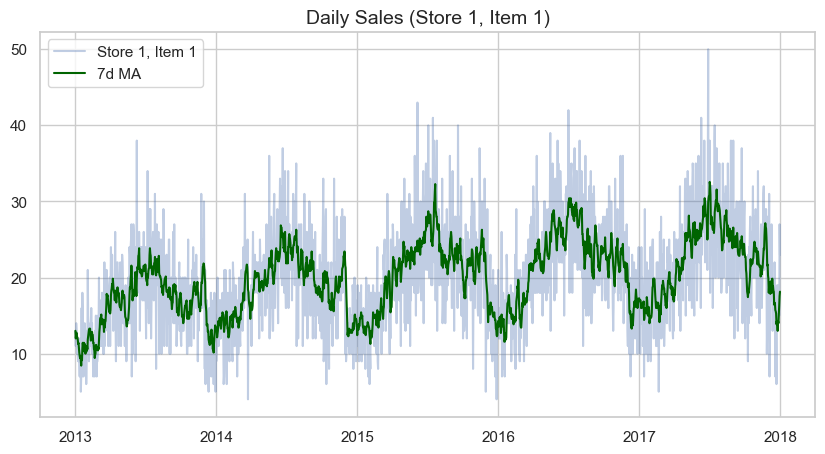

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [26]:
if df_vis is None:
    print("Skipping time series plots: no data.")
else:
    # Overall daily mean sales
    daily_mean = df_vis.groupby('date', as_index=False)['sales'].mean()
    fig, ax = plt.subplots()
    ax.plot(daily_mean['date'], daily_mean['sales'], color='#1f77b4', label='Daily mean sales (all)')
    ax.set_title('Overall Daily Mean Sales')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()
    plt.show()

    # Rolling average (7-day)
    daily_mean['sales_7d_ma'] = daily_mean['sales'].rolling(7, min_periods=1).mean()
    fig, ax = plt.subplots()
    ax.plot(daily_mean['date'], daily_mean['sales'], alpha=0.35, label='Daily mean')
    ax.plot(daily_mean['date'], daily_mean['sales_7d_ma'], color='crimson', label='7d MA')
    ax.set_title('Overall Daily Mean Sales with 7-day Moving Average')
    ax.legend()
    plt.show()

    # Choose a default store-item
    sel_store, sel_item = 1, 1
    sub = df_vis[(df_vis['store']==sel_store) & (df_vis['item']==sel_item)].copy()
    if len(sub) > 0:
        sub = sub.sort_values('date')
        sub['sales_7d_ma'] = sub['sales'].rolling(7, min_periods=1).mean()
        fig, ax = plt.subplots()
        ax.plot(sub['date'], sub['sales'], alpha=0.35, label=f'Store {sel_store}, Item {sel_item}')
        ax.plot(sub['date'], sub['sales_7d_ma'], color='darkgreen', label='7d MA')
        ax.set_title(f'Daily Sales (Store {sel_store}, Item {sel_item})')
        ax.legend()
        plt.show()

        # Interactive plotly for the same selection
        fig_px = px.line(sub, x='date', y='sales', title=f'Interactive: Sales (Store {sel_store}, Item {sel_item})')
        fig_px.update_traces(line_color='#9467bd')
        fig_px.show()
    else:
        print(f"No data for store={sel_store}, item={sel_item}")


## 10. Seasonal Patterns

- Sales by day of week and month (boxplots)
- Calendar-like heatmap: Month vs Day-of-Week average sales

In [ ]:
if df_vis is None:
    print("Skipping seasonal plots: no data.")
else:
    # Boxplot by day of week
    fig, ax = plt.subplots()
    sns.boxplot(data=df_vis, x='dayofweek', y='sales', ax=ax, palette='viridis')
    ax.set_title('Sales by Day of Week')
    ax.set_xlabel('Day of Week (Mon=0)')
    plt.show()

    # Boxplot by month
    fig, ax = plt.subplots()
    sns.boxplot(data=df_vis, x='month', y='sales', ax=ax, palette='magma')
    ax.set_title('Sales by Month')
    plt.show()

    # Heatmap: average sales by dayofweek x month
    piv = df_vis.pivot_table(index='dayofweek', columns='month', values='sales', aggfunc='mean')
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.heatmap(piv, annot=False, cmap='YlGnBu', ax=ax)
    ax.set_title('Average Sales Heatmap (Day-of-Week vs Month)')
    plt.show()


## 11. Distribution of Sales

- Histogram and KDE of sales values
- Optional log scale to inspect long tails

In [ ]:
if df_vis is None:
    print("Skipping distribution plots: no data.")
else:
    fig, ax = plt.subplots()
    sns.histplot(df_vis['sales'], bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of Sales (Histogram + KDE)')
    plt.show()

    # Log-scale view (avoid log of zero)
    sales_pos = df_vis['sales'].clip(lower=1)
    fig, ax = plt.subplots()
    sns.histplot(np.log1p(sales_pos), bins=50, kde=True, ax=ax, color='teal')
    ax.set_title('Distribution of log(1+Sales)')
    plt.show()


## 12. Model Metrics Visualizations

Visualize metrics from `uploads/model_metrics.csv` if present.

In [ ]:
metrics_path = UPLOADS_DIR / 'model_metrics.csv'
if not metrics_path.exists():
    print("No metrics file found at:", metrics_path)
else:
    mdf = pd.read_csv(metrics_path)
    display(mdf)

    # Bar charts for R2 and RMSE
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(data=mdf, x='Model', y='R2 Score (Test)', ax=axes[0], palette='crest')
    axes[0].set_title('R2 Score by Model')
    axes[0].tick_params(axis='x', rotation=30)

    sns.barplot(data=mdf, x='Model', y='RMSE (Test)', ax=axes[1], palette='flare')
    axes[1].set_title('RMSE by Model (lower is better)')
    axes[1].tick_params(axis='x', rotation=30)
    plt.show()

    # Plotly interactive: R2 vs RMSE bubble chart
    if 'RMSPE (Test)' in mdf.columns:
        # Convert RMSPE string percentages to numeric where possible
        def _to_float_pct(v):
            try:
                return float(str(v).replace('%',''))
            except:
                return None
        mdf['_RMSPE_num'] = mdf['RMSPE (Test)'].apply(_to_float_pct)
    fig_px = px.scatter(mdf, x='RMSE (Test)', y='R2 Score (Test)', color='Model', size=mdf.get('_RMSPE_num'),
                        title='Model Comparison: R2 vs RMSE (bubble size ~ RMSPE)')
    fig_px.show()


## 13. Predicted vs Actual and Residuals (Holdout)

We will recompute a time-based holdout (last 20% of records) and visualize:
- Predicted vs Actual scatter with identity line
- Residual distribution
- Residuals vs Predicted

We will downsample points for plotting to keep it responsive.

In [ ]:
if df_vis is None or not models:
    print("Cannot compute residual plots: missing data or models.")
else:
    # Prepare holdout set
    df_eval = df_vis.sort_values('date').reset_index(drop=True)
    n = len(df_eval)
    n_test = max(1, int(0.2 * n))
    test_df = df_eval.iloc[-n_test:].copy()

    feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
    X_test = test_df[feature_cols]
    y_test = test_df['sales'].to_numpy()
    X_test_scaled = scaler.transform(X_test)

    # Evaluate all models for plots
    preds_by_model = {}
    for key, mdl in models.items():
        try:
            preds = np.ravel(mdl.predict(X_test_scaled))
            preds_by_model[key] = preds
        except Exception as e:
            print(f"Skipping {key}: {e}")

    # Downsample for plotting if too large
    max_points = 10000
    idx = np.arange(len(y_test))
    if len(idx) > max_points:
        rng = np.random.default_rng(42)
        idx = rng.choice(idx, size=max_points, replace=False)
    y_sample = y_test[idx]

    # Predicted vs Actual for each model
    n_models = len(preds_by_model)
    if n_models:
        cols = min(3, n_models)
        rows = int(np.ceil(n_models / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols+2, 4*rows+1))
        axes = np.array(axes).reshape(rows, cols)
        for ax in axes.ravel():
            ax.axis('off')
        i = 0
        for key, preds in preds_by_model.items():
            r = i // cols; c = i % cols; ax = axes[r, c]
            ax.axis('on')
            ax.scatter(y_sample, preds[idx], s=8, alpha=0.4)
            lims = [min(y_sample.min(), preds[idx].min()), max(y_sample.max(), preds[idx].max())]
            ax.plot(lims, lims, 'r--', linewidth=1)
            ax.set_title(f"Pred vs Actual: {key}")
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')
            i += 1
        plt.tight_layout()
        plt.show()

        # Residual histograms
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols+2, 4*rows+1))
        axes = np.array(axes).reshape(rows, cols)
        for ax in axes.ravel():
            ax.axis('off')
        i = 0
        for key, preds in preds_by_model.items():
            r = i // cols; c = i % cols; ax = axes[r, c]
            ax.axis('on')
            resid = preds[idx] - y_sample
            sns.histplot(resid, bins=40, ax=ax, kde=True)
            ax.set_title(f"Residuals: {key}")
            ax.set_xlabel('Prediction Error')
            i += 1
        plt.tight_layout()
        plt.show()

        # Residual vs Predicted
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols+2, 4*rows+1))
        axes = np.array(axes).reshape(rows, cols)
        for ax in axes.ravel():
            ax.axis('off')
        i = 0
        for key, preds in preds_by_model.items():
            r = i // cols; c = i % cols; ax = axes[r, c]
            ax.axis('on')
            resid = preds[idx] - y_sample
            ax.scatter(preds[idx], resid, s=8, alpha=0.4)
            ax.axhline(0, color='r', linestyle='--', linewidth=1)
            ax.set_title(f"Residual vs Predicted: {key}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Residual')
            i += 1
        plt.tight_layout()
        plt.show()

        # Interactive Pred vs Actual for preferred model
        preferred = next(iter(preds_by_model))
        df_plot = pd.DataFrame({'Actual': y_sample, 'Predicted': preds_by_model[preferred][idx]})
        fig_px = px.scatter(df_plot, x='Actual', y='Predicted', title=f'Interactive Pred vs Actual: {preferred}', trendline='ols')
        fig_px.add_shape(type='line', x0=df_plot['Actual'].min(), y0=df_plot['Actual'].min(),
                         x1=df_plot['Actual'].max(), y1=df_plot['Actual'].max(), line=dict(color='red', dash='dash'))
        fig_px.show()
    else:
        print("No predictions available for plotting.")


## 14. Feature Importance

Bar plots of feature importance for tree models; coefficients magnitude for linear models (e.g., Ridge).

In [ ]:
feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
if not models:
    print("No models loaded.")
else:
    for key, mdl in models.items():
        try:
            if hasattr(mdl, 'feature_importances_'):
                importances = np.array(mdl.feature_importances_, dtype=float)
                fi = pd.DataFrame({'feature': feature_cols, 'importance': importances})
                fi = fi.sort_values('importance', ascending=False)
                fig, ax = plt.subplots(figsize=(8,4))
                sns.barplot(data=fi, x='importance', y='feature', ax=ax, palette='Blues_r')
                ax.set_title(f'Feature Importance: {key}')
                plt.show()
            elif hasattr(mdl, 'coef_'):
                coef = np.ravel(mdl.coef_)
                fi = pd.DataFrame({'feature': feature_cols, 'coef': coef})
                fi['importance'] = fi['coef'].abs()
                fi = fi.sort_values('importance', ascending=False)
                fig, ax = plt.subplots(figsize=(8,4))
                sns.barplot(data=fi, x='importance', y='feature', ax=ax, palette='Oranges_r')
                ax.set_title(f'Coefficient Magnitudes: {key}')
                plt.show()
            else:
                print(f"Model {key} has no importances or coefficients exposed; skipping.")
        except Exception as e:
            print(f"Skipping importance for {key}: {e}")


## 15. Error by Category

Group errors by calendar categories to see where models struggle:
- RMSE by Day of Week
- RMSE by Month

In [ ]:
if df_vis is None or not models:
    print("Cannot compute error-by-category: missing data or models.")
else:
    # Reuse the holdout split
    df_eval = df_vis.sort_values('date').reset_index(drop=True)
    n = len(df_eval)
    n_test = max(1, int(0.2 * n))
    test_df = df_eval.iloc[-n_test:].copy()

    feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
    X_test = test_df[feature_cols]
    y_test = test_df['sales'].to_numpy()
    X_test_scaled = scaler.transform(X_test)

    # Pick preferred model for category analysis
    preferred_order = ['lightgbm', 'catboost', 'random_forest', 'xgboost', 'ridge']
    model_key = next((k for k in preferred_order if k in models), next(iter(models.keys())))
    mdl = models[model_key]
    y_pred = np.ravel(mdl.predict(X_test_scaled))

    err_df = test_df[['dayofweek','month']].copy()
    err_df['y_true'] = y_test
    err_df['y_pred'] = y_pred
    err_df['residual'] = err_df['y_pred'] - err_df['y_true']

    # RMSE by dayofweek
    rmse_dow = err_df.groupby('dayofweek').apply(lambda x: float(np.sqrt(np.mean((x['residual'])**2)))).reset_index(name='RMSE')
    fig, ax = plt.subplots()
    sns.barplot(data=rmse_dow, x='dayofweek', y='RMSE', ax=ax, palette='viridis')
    ax.set_title(f'RMSE by Day of Week ({model_key})')
    plt.show()

    # RMSE by month
    rmse_mon = err_df.groupby('month').apply(lambda x: float(np.sqrt(np.mean((x['residual'])**2)))).reset_index(name='RMSE')
    fig, ax = plt.subplots()
    sns.barplot(data=rmse_mon, x='month', y='RMSE', ax=ax, palette='magma')
    ax.set_title(f'RMSE by Month ({model_key})')
    plt.show()
